<a href="https://colab.research.google.com/github/albert-h-wong/DS-Unit-4-Sprint-3-Neural-Networks/blob/master/DS43SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks Sprint Challenge

## 1) Define the following terms:

- Neuron
- Input Layer
- Hidden Layer
- Output Layer
- Activation
- Backpropagation

### Neuron:
An artificial neuron is a mathematical function with elementary units in an artificial neural network. The artificial neuron receives one or more inputs and sums them to produce an output. Usually each input is separately weighted, and the sum is passed through a non-linear function known as an activation  or transfer function.

### Input Layer:

The Input Layer is the 1st neuron layer which receives input from a dataset. Also known as the visible layer as it's the only part that the data interacts with directly. Typically node maps within the input layer corresponds with one input node for each of the different features to be used in the dataset that will be passed to the neural network.

### Hidden Layer:

The neuron layers between Input layer and Output layer are called Hidden layers since it cannot be accessed directly. Weighted sum of inputs and bias from previous layers are passed onto hidden layer for processing. There can be multiple hidden layers which refers to Deep Learning. There is also an activation function that processes the data before output to the next layer.

### Output Layer:

The final layer of Neural Network is called Output layer. The purpose of the output layer is to output a vector of values that is in a format that is suitable for the type of problem that we're trying to address. This is handled using activation functions based on the problem.
1. Regression - Single output node for providing continous value.
2. Binary Classification - Sigmoid activation function in order to squishify values down to represent a probability.
3. Multi-class classification - Softmax function might have multiple output nodes in the output layer, one for each class that we're trying to predict.

### Activation Function:

In artificial neural networks, the activation function of a node defines the output of that node, or "neuron," given an input or set of inputs. This output is then used as input for the next node in the following layer or the final output layer. It maps the resulting values into the targeted range and affects the form of the signal passing on such as between 0 to 1 or -1 to 1 etc. (depending upon the choice of activation function). 

### Backpropagation:

Backpropagation is short for "Backwards Propagation of errors" and refers to a specific (rather calculus intensive) algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch.


## 2) Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 1  | 1  | 1  | 1 |
| 1  | 0  | 1  | 0 |
| 0  | 1  | 1  | 0 |
| 0  | 0  | 1  | 0 |

In [0]:
import numpy as np

In [0]:
inputs = np.array(([1, 1, 1],
              [1, 0, 1],
              [0, 1, 1],
              [0, 0, 1]), dtype=float)
correct_outputs = np.array(([1],
              [0],
              [0],
              [0]), dtype=float)

weights = 2 * np.random.random((3,1)) - 1

In [0]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  return sigmoid(x) * (1 - sigmoid(x))

In [54]:
for iteration in range(10000):
  
    # Weighted sum of inputs and weights
    weighted_sum = np.dot(inputs, weights)

    # Activate with sigmoid function
    activated_output = sigmoid(weighted_sum)

    # Calculate Error
    error = correct_outputs - activated_output

    # Calculate weight adjustments with sigmoid_derivative
    adjustments = error * sigmoid_derivative(activated_output)

    # Update weights
    weights += np.dot(inputs.T, adjustments)
    
  
print('optimized weights after training: ')
print(weights)

print("Output After Training:")
print(activated_output)

optimized weights after training: 
[[ 11.83990338]
 [ 11.83990338]
 [-18.0481643 ]]
Output After Training:
[[9.96429746e-01]
 [2.00889314e-03]
 [2.00889314e-03]
 [1.45181975e-08]]


In [0]:
class Neural_Network(object):
  def __init__(self):
    self.inputs = 3
    self.hiddenNodes = 3
    self.outputNodes = 1

    # Initlize Weights
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (3x3)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (4x1)

  def feed_forward(self, inputs):
    # Weighted sum between inputs and hidden layer
    self.hidden_sum = np.dot(inputs, self.L1_weights)
    # Activations of weighted sum
    # self.activated_hidden = self.sigmoid(self.hidden_sum)
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    # Weighted sum between hidden and output
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    # final activation of output
    # self.activated_output = self.sigmoid(self.output_sum)
    self.activated_output = self.sigmoid(self.output_sum)
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))
  
  def sigmoidPrime(self, s):
    return s * (1 - s)
  
  def backward(self, inputs, correct_outputs, o):
    # backward propgate through the network
    self.o_error = correct_outputs - o # error in output
    #self.o_delta = self.o_error*self.sigmoidPrime(o) # applying derivative of sigmoid to error
    self.o_delta = self.o_error*self.sigmoidPrime(o)
    
    self.z2_error = self.o_delta.dot(self.L2_weights.T) # z2 error: how much our hidden layer weights contributed to output error
    #self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden) # applying derivative of sigmoid to z2 error
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden)
    

    self.L1_weights += inputs.T.dot(self.z2_delta) # adjusting first set (input --> hidden) weights
    self.L2_weights += self.activated_hidden.T.dot(self.o_delta) # adjusting second set (hidden --> output) weights
    
  def train (self, inputs, correct_outputs):
    o = self.feed_forward(inputs)
    self.backward(inputs, correct_outputs, o)

In [56]:
NN = Neural_Network()
for i in range(1000): # trains the NN 1000 times
  if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
    print('+---------- EPOCH', i+1, '-----------+')
    print("Input: \n", inputs) 
    print("Actual Output: \n", correct_outputs)  
    print("Predicted Output: \n" + str(NN.feed_forward(inputs))) 
    print("Loss: \n" + str(np.mean(np.square(correct_outputs - NN.feed_forward(inputs))))) # mean sum squared loss
    print("\n")
  NN.train(inputs, correct_outputs)

+---------- EPOCH 1 -----------+
Input: 
 [[1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [0. 0. 1.]]
Actual Output: 
 [[1.]
 [0.]
 [0.]
 [0.]]
Predicted Output: 
[[0.38311907]
 [0.35888655]
 [0.36564236]
 [0.25805964]]
Loss: 
0.17740768705257998


+---------- EPOCH 2 -----------+
Input: 
 [[1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [0. 0. 1.]]
Actual Output: 
 [[1.]
 [0.]
 [0.]
 [0.]]
Predicted Output: 
[[0.3873062 ]
 [0.35207675]
 [0.36316747]
 [0.24774057]]
Loss: 
0.17315443098230773


+---------- EPOCH 3 -----------+
Input: 
 [[1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [0. 0. 1.]]
Actual Output: 
 [[1.]
 [0.]
 [0.]
 [0.]]
Predicted Output: 
[[0.39185533]
 [0.34523977]
 [0.36064973]
 [0.23764666]]
Loss: 
0.1688936500037653


+---------- EPOCH 4 -----------+
Input: 
 [[1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [0. 0. 1.]]
Actual Output: 
 [[1.]
 [0.]
 [0.]
 [0.]]
Predicted Output: 
[[0.39675341]
 [0.33841018]
 [0.35808667]
 [0.22782507]]
Loss: 
0.16463955641437975


+---------- EPOCH 5 -----------+
Input: 
 [[1. 1.

## 3) Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. 
- Your network must have one hidden layer. 
- You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
- Train your model on the Heart Disease dataset from UCI:

[Github Dataset](https://github.com/ryanleeallred/datasets/blob/master/heart.csv)

[Raw File on Github](https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv)


In [66]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')
data.shape

(303, 14)

In [67]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
X = data.copy().drop(columns='target')
y = data.target == 1

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(-1,13)
y = np.array(y).reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
# Let's make a larger NN, with 1 hidden layer of 13, and an output of 1 variable
class Neural_Network_2(object):
    def __init__(self):
        self.inputs = 13
        self.L1Nodes = 13
        self.outputNodes = 1

        # Initlize Weights
        self.L1_weights = np.random.randn(self.inputs, self.L1Nodes) 
        self.output_weights = np.random.randn(self.L1Nodes, self.outputNodes) 

    def feed_forward(self, X):
        # Sum and activate flows to L1
        self.activated_L1 = self.sigmoid(np.dot(X, self.L1_weights)) 
        # Sum and activate flows to output
        self.activated_output = self.sigmoid(np.dot(self.activated_L1, self.output_weights))
        return self.activated_output
        
    def sigmoid(self, s):
        return 1/(1+np.exp(-s))
    
    def sigmoidPrime(self, s):
        return s * (1 - s)
    
    def backward(self, X, y, output):
        ## backward propgate through the network, calculating error and delta at each layer
        # Output
        self.output_error = y - output # error in this layer
        self.output_delta = self.output_error*self.sigmoidPrime(output) # apply derivative of sigmoid to error
        
        # L1
        self.L1_error = self.output_delta.dot(self.output_weights.T) 
        self.L1_delta = self.L1_error*self.sigmoidPrime(self.activated_L1)
        
        
        ## Update all weights 
        self.L1_weights += X.T.dot(self.L1_delta)
        self.output_weights += self.activated_L1.T.dot(self.output_delta)
        
    def train (self, X, y):
        output = self.feed_forward(X)
        self.backward(X, y, output)

In [74]:
nn2 = Neural_Network_2()
for i in range(1000): # trains the NN 1000 times
  if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
    print('+---------- EPOCH', i+1, '-----------+')
    print("Loss: \n" + str(np.mean(np.square(y - nn2.feed_forward(X))))) # mean sum squared loss
    print("\n")
  nn2.train(X, y)

+---------- EPOCH 1 -----------+
Loss: 
0.41355831162489337


+---------- EPOCH 2 -----------+
Loss: 
0.4551120873791289


+---------- EPOCH 3 -----------+
Loss: 
0.4548826168706793


+---------- EPOCH 4 -----------+
Loss: 
0.4542045854351928


+---------- EPOCH 5 -----------+
Loss: 
0.4521405101266872


+---------- EPOCH 50 -----------+
Loss: 
0.06903110742082859


+---------- EPOCH 100 -----------+
Loss: 
0.06284288393956154


+---------- EPOCH 150 -----------+
Loss: 
0.05725156999971885


+---------- EPOCH 200 -----------+
Loss: 
0.04968203505586793


+---------- EPOCH 250 -----------+
Loss: 
0.04636169103382447


+---------- EPOCH 300 -----------+
Loss: 
0.036480022290331156


+---------- EPOCH 350 -----------+
Loss: 
0.03639046460389278


+---------- EPOCH 400 -----------+
Loss: 
0.036365826144512316


+---------- EPOCH 450 -----------+
Loss: 
0.03594126526258277


+---------- EPOCH 500 -----------+
Loss: 
0.026745305142397025


+---------- EPOCH 550 -----------+
Loss: 
0.02656637

## 4) Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy. 

- Use the Heart Disease Dataset (binary classification)
- Use an appropriate loss function for a binary classification task
- Use an appropriate activation function on the final layer of your network. 
- Train your model using verbose output for ease of grading.
- Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
- When hyperparameter tuning, show you work by adding code cells for each new experiment. 
- Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
- You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Nadam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

SEED = 42

In [0]:
X = data.copy().drop(columns='target')
y = data.target == 1

In [77]:
X = scaler.fit_transform(X)
X = X.reshape(-1,13)
y = np.array(y).reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [78]:
# Baseline model

np.random.seed(SEED)

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# define the grid search parameters
batch_size = [20]
epochs = [20]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result1 = grid.fit(X, y)

Epoch 1/20
202/202 [==============================] - 15s 76ms/step - loss: 0.6830 - acc: 0.5891
Epoch 2/20
202/202 [==============================] - 0s 335us/step - loss: 0.6497 - acc: 0.6287
Epoch 3/20
202/202 [==============================] - 0s 312us/step - loss: 0.6238 - acc: 0.6683
Epoch 4/20
202/202 [==============================] - 0s 352us/step - loss: 0.6001 - acc: 0.6881
Epoch 5/20
202/202 [==============================] - 0s 314us/step - loss: 0.5785 - acc: 0.7079
Epoch 6/20
202/202 [==============================] - 0s 349us/step - loss: 0.5596 - acc: 0.7327
Epoch 7/20
202/202 [==============================] - 0s 382us/step - loss: 0.5422 - acc: 0.7475
Epoch 8/20
202/202 [==============================] - 0s 292us/step - loss: 0.5263 - acc: 0.7624
Epoch 9/20
202/202 [==============================] - 0s 447us/step - loss: 0.5128 - acc: 0.7673
Epoch 10/20
202/202 [==============================] - 0s 458us/step - loss: 0.5012 - acc: 0.7673
Epoch 11/20
202/202 [========

Best: 0.776 using {'batch_size': 20, 'epochs': 20}

Means: 0.776, Stdev: 0.034 with: {'batch_size': 20, 'epochs': 20}


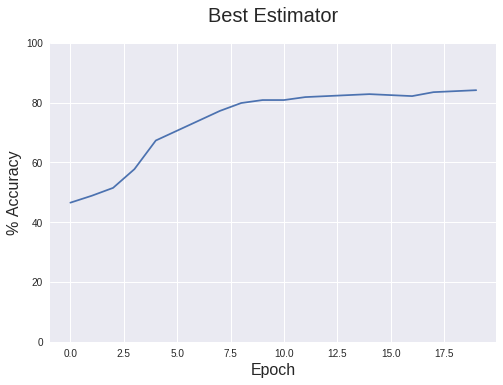

In [79]:
# Baseline results

grid_result = grid_result1

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

In [80]:
# Tune batch size and epochs
# define the grid search parameters
batch_size = [10, 20, 30, 50]
epochs = [10, 20, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result2 = grid.fit(X, y)

Epoch 1/10
202/202 [==============================] - 15s 76ms/step - loss: 0.8346 - acc: 0.4901
Epoch 2/10
202/202 [==============================] - 0s 516us/step - loss: 0.7732 - acc: 0.5198
Epoch 3/10
202/202 [==============================] - 0s 644us/step - loss: 0.7269 - acc: 0.5446
Epoch 4/10
202/202 [==============================] - 0s 636us/step - loss: 0.6858 - acc: 0.5842
Epoch 5/10
202/202 [==============================] - 0s 535us/step - loss: 0.6515 - acc: 0.6188
Epoch 6/10
202/202 [==============================] - 0s 540us/step - loss: 0.6208 - acc: 0.6584
Epoch 7/10
202/202 [==============================] - 0s 523us/step - loss: 0.5940 - acc: 0.6931
Epoch 8/10
202/202 [==============================] - 0s 609us/step - loss: 0.5680 - acc: 0.7327
Epoch 9/10
202/202 [==============================] - 0s 747us/step - loss: 0.5468 - acc: 0.7574
Epoch 10/10
202/202 [==============================] - 0s 515us/step
Epoch 1/10
202/202 [==============================] - 15s 

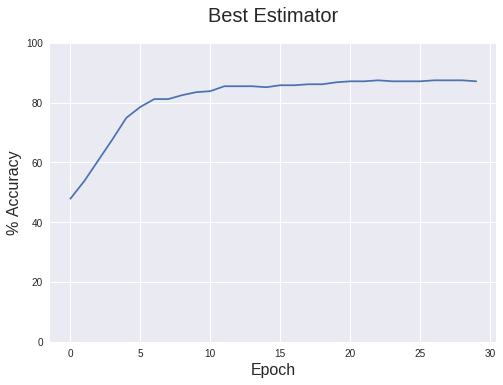

Best: 0.832 using {'batch_size': 10, 'epochs': 30}

Means: 73.927, Stdev: 1.867 with: {'batch_size': 10, 'epochs': 10}
Means: 81.518, Stdev: 3.061 with: {'batch_size': 10, 'epochs': 20}
Means: 83.168, Stdev: 4.917 with: {'batch_size': 10, 'epochs': 30}
Means: 75.248, Stdev: 2.425 with: {'batch_size': 20, 'epochs': 10}
Means: 79.538, Stdev: 4.737 with: {'batch_size': 20, 'epochs': 20}
Means: 81.188, Stdev: 1.617 with: {'batch_size': 20, 'epochs': 30}
Means: 72.937, Stdev: 3.061 with: {'batch_size': 30, 'epochs': 10}
Means: 78.878, Stdev: 2.599 with: {'batch_size': 30, 'epochs': 20}
Means: 78.878, Stdev: 4.452 with: {'batch_size': 30, 'epochs': 30}
Means: 74.257, Stdev: 2.915 with: {'batch_size': 50, 'epochs': 10}
Means: 63.366, Stdev: 9.835 with: {'batch_size': 50, 'epochs': 20}
Means: 80.198, Stdev: 3.234 with: {'batch_size': 50, 'epochs': 30}


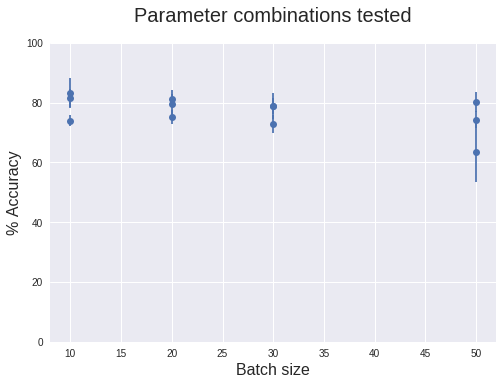

In [81]:
grid_result = grid_result2

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
batch_size = [x['batch_size'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Batch size', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax = plt.errorbar(batch_size, means, yerr=stds, fmt='o',
                 capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

In [83]:
# Tune # of folds in CV and optimizer
# Parameters
# -----------------------------------------------

optimizer = ['adam','sgd','rmsprop','nadam']
param_grid = dict(optimizer=optimizer)
n_folds = 5
# -----------------------------------------------

# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1, batch_size=20, epochs=20)

# define cross validation test harness
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result3 = grid.fit(X, y)

Epoch 1/20
242/242 [==============================] - 18s 76ms/step - loss: 0.8242 - acc: 0.4793
Epoch 2/20
242/242 [==============================] - 0s 450us/step - loss: 0.7768 - acc: 0.4959
Epoch 3/20
242/242 [==============================] - 0s 462us/step - loss: 0.7378 - acc: 0.5165
Epoch 4/20
242/242 [==============================] - 0s 442us/step - loss: 0.7012 - acc: 0.5207
Epoch 5/20
242/242 [==============================] - 0s 430us/step - loss: 0.6699 - acc: 0.5413
Epoch 6/20
242/242 [==============================] - 0s 443us/step - loss: 0.6414 - acc: 0.5661
Epoch 7/20
242/242 [==============================] - 0s 479us/step - loss: 0.6155 - acc: 0.5992
Epoch 8/20
242/242 [==============================] - 0s 466us/step - loss: 0.5929 - acc: 0.6033
Epoch 9/20
242/242 [==============================] - 0s 466us/step - loss: 0.5710 - acc: 0.6364
Epoch 10/20
242/242 [==============================] - 0s 487us/step - loss: 0.5510 - acc: 0.6736
Epoch 11/20
242/242 [========

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/20
303/303 [==============================] - 21s 68ms/step - loss: 0.6937 - acc: 0.5413
Epoch 2/20
303/303 [==============================] - 0s 493us/step - loss: 0.6168 - acc: 0.6601
Epoch 3/20
303/303 [==============================] - 0s 504us/step - loss: 0.5570 - acc: 0.7228
Epoch 4/20
303/303 [==============================] - 0s 517us/step - loss: 0.5090 - acc: 0.7657
Epoch 5/20
303/303 [==============================] - 0s 515us/step - loss: 0.4714 - acc: 0.7921
Epoch 6/20
303/303 [==============================] - 0s 519us/step - loss: 0.4437 - acc: 0.8086
Epoch 7/20
303/303 [==============================] - 0s 538us/step - loss: 0.4223 - acc: 0.8152
Epoch 8/20
303/303 [==============================] - 0s 490us/step - loss: 0.4049 - acc: 0.8152
Epoch 9/20
303/303 [==============================] - 0s 540us/step - loss: 0.3908 - acc: 0.8119
Epoch 10/20
303/303 [==============================] - 0s 544us/step - loss: 0.3793 - acc: 0.8152
Epoch 11/20
303/303 [========

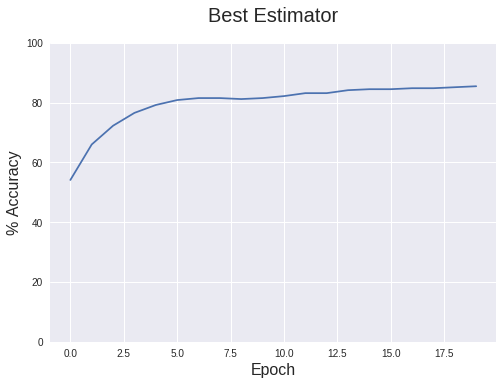

Best: 0.828 using {'optimizer': 'nadam'}

Means: 82.178, Stdev: 1.194 with: {'optimizer': 'adam'}
Means: 76.898, Stdev: 4.451 with: {'optimizer': 'sgd'}
Means: 81.518, Stdev: 5.250 with: {'optimizer': 'rmsprop'}
Means: 82.838, Stdev: 4.561 with: {'optimizer': 'nadam'}


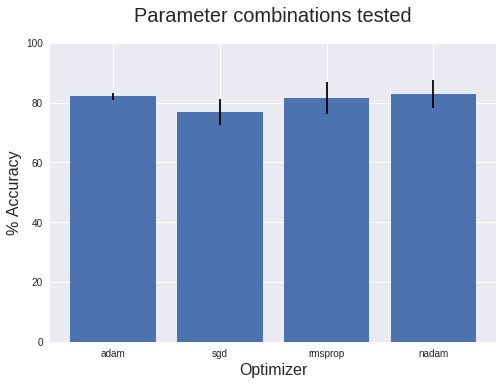

In [84]:
grid_result = grid_result3

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['optimizer'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Optimizer', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

In [85]:
# Tune # of hidden layers
# -----------------------------------------------

n_hidden_layers = [1,2,3]
param_grid = dict(n_hidden_layers=n_hidden_layers)
# -----------------------------------------------

# Function to create model, required for KerasClassifier
def create_model(n_hidden_layers):
    model = Sequential()
    
    for i in range(n_hidden_layers):
        model.add(Dense(13, input_dim=13, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1,
                       batch_size=20, epochs=20)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result4 = grid.fit(X, y)

Epoch 1/20
202/202 [==============================] - 21s 103ms/step - loss: 0.6640 - acc: 0.6139
Epoch 2/20
202/202 [==============================] - 0s 530us/step - loss: 0.6341 - acc: 0.6337
Epoch 3/20
202/202 [==============================] - 0s 517us/step - loss: 0.6086 - acc: 0.6584
Epoch 4/20
202/202 [==============================] - 0s 518us/step - loss: 0.5864 - acc: 0.6931
Epoch 5/20
202/202 [==============================] - 0s 536us/step - loss: 0.5663 - acc: 0.7079
Epoch 6/20
202/202 [==============================] - 0s 507us/step - loss: 0.5473 - acc: 0.7079
Epoch 7/20
202/202 [==============================] - 0s 496us/step - loss: 0.5292 - acc: 0.7327
Epoch 8/20
202/202 [==============================] - 0s 424us/step - loss: 0.5126 - acc: 0.7475
Epoch 9/20
202/202 [==============================] - 0s 370us/step - loss: 0.4999 - acc: 0.7525
Epoch 10/20
202/202 [==============================] - 0s 443us/step - loss: 0.4883 - acc: 0.7624
Epoch 11/20
202/202 [=======

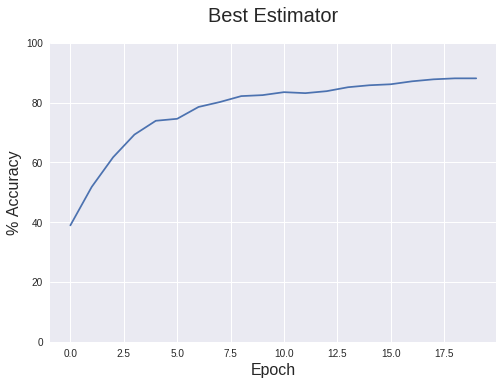

Best: 0.828 using {'n_hidden_layers': 3}

Means: 79.538, Stdev: 2.599 with: {'n_hidden_layers': 1}
Means: 76.568, Stdev: 3.267 with: {'n_hidden_layers': 2}
Means: 82.838, Stdev: 2.599 with: {'n_hidden_layers': 3}


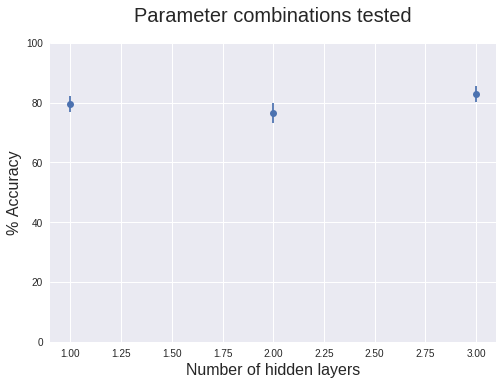

In [86]:
grid_result = grid_result4

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['n_hidden_layers'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Number of hidden layers', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax = plt.errorbar(var, means, yerr=stds, fmt='o', capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

In [87]:
from keras import optimizers

# Tune learning rate
# -----------------------------------------------
lr = [.0001, .001, .01, .1]
param_grid = dict(lr=lr)
# -----------------------------------------------

# Function to create model, required for KerasClassifier
def create_model(lr):
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    adam = optimizers.Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1,
                       batch_size=20, epochs=20)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result5 = grid.fit(X, y)

Epoch 1/20
202/202 [==============================] - 22s 110ms/step - loss: 0.7874 - acc: 0.4901
Epoch 2/20
202/202 [==============================] - 0s 533us/step - loss: 0.7816 - acc: 0.5099
Epoch 3/20
202/202 [==============================] - 0s 544us/step - loss: 0.7761 - acc: 0.5149
Epoch 4/20
202/202 [==============================] - 0s 562us/step - loss: 0.7708 - acc: 0.5248
Epoch 5/20
202/202 [==============================] - 0s 545us/step - loss: 0.7655 - acc: 0.5297
Epoch 6/20
202/202 [==============================] - 0s 428us/step - loss: 0.7600 - acc: 0.5297
Epoch 7/20
202/202 [==============================] - 0s 450us/step - loss: 0.7547 - acc: 0.5347
Epoch 8/20
202/202 [==============================] - 0s 445us/step - loss: 0.7498 - acc: 0.5347
Epoch 9/20
202/202 [==============================] - 0s 542us/step - loss: 0.7452 - acc: 0.5347
Epoch 10/20
202/202 [==============================] - 0s 546us/step - loss: 0.7404 - acc: 0.5347
Epoch 11/20
202/202 [=======

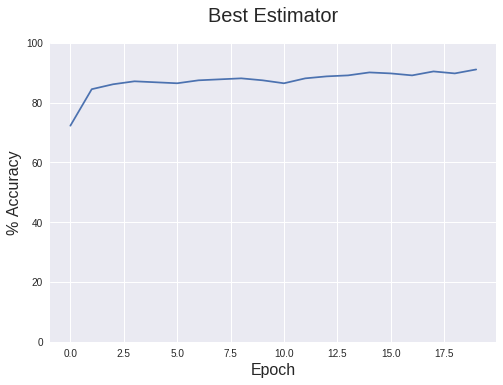

Best: 0.825 using {'lr': 0.01}

1 Means: 59.076, Stdev: 8.257 with: {'lr': 0.0001}
2 Means: 78.878, Stdev: 3.267 with: {'lr': 0.001}
3 Means: 82.508, Stdev: 3.645 with: {'lr': 0.01}


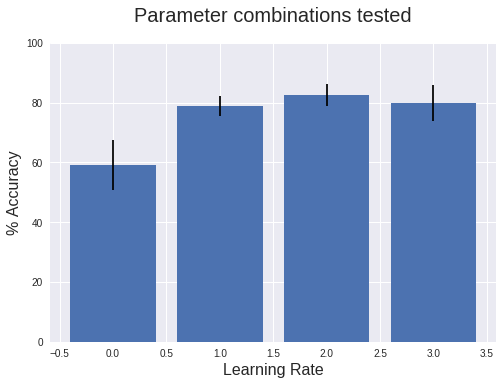

In [88]:
grid_result = grid_result5

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param, idx in zip(means, stds, params, var):
    print(f"{idx} Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = list(range(4))

fig, ax = plt.subplots()
ax.set_xlabel('Learning Rate', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

In [89]:
# Tune activation
# -----------------------------------------------
activation = ['relu','sigmoid']
param_grid = dict(activation=activation)
# -----------------------------------------------

# Function to create model, required for KerasClassifier
def create_model(activation):
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1,
                       batch_size=20, epochs=20)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result6 = grid.fit(X, y)

Epoch 1/20
202/202 [==============================] - 23s 116ms/step - loss: 0.6867 - acc: 0.5743
Epoch 2/20
202/202 [==============================] - 0s 500us/step - loss: 0.6495 - acc: 0.6188
Epoch 3/20
202/202 [==============================] - 0s 535us/step - loss: 0.6176 - acc: 0.6584
Epoch 4/20
202/202 [==============================] - 0s 466us/step - loss: 0.5934 - acc: 0.6931
Epoch 5/20
202/202 [==============================] - 0s 483us/step - loss: 0.5707 - acc: 0.7129
Epoch 6/20
202/202 [==============================] - 0s 544us/step - loss: 0.5510 - acc: 0.7376
Epoch 7/20
202/202 [==============================] - 0s 556us/step - loss: 0.5337 - acc: 0.7574
Epoch 8/20
202/202 [==============================] - 0s 546us/step - loss: 0.5156 - acc: 0.7673
Epoch 9/20
202/202 [==============================] - 0s 553us/step - loss: 0.4997 - acc: 0.7772
Epoch 10/20
202/202 [==============================] - 0s 491us/step - loss: 0.4852 - acc: 0.7871
Epoch 11/20
202/202 [=======

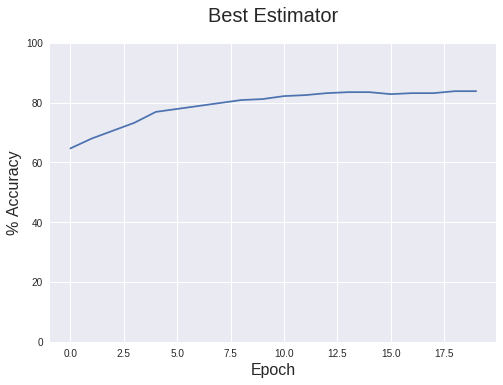

Best: 0.799 using {'activation': 'relu'}

Means: 79.868, Stdev: 0.467 with: {'activation': 'relu'}
Means: 79.208, Stdev: 4.042 with: {'activation': 'sigmoid'}


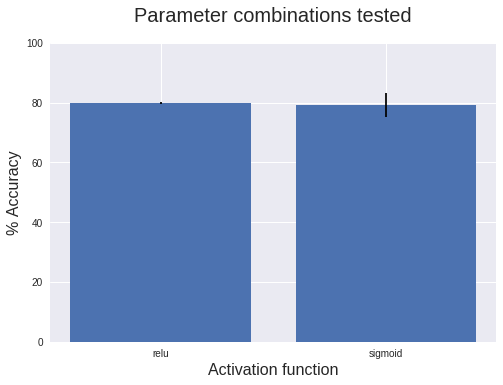

In [90]:
grid_result = grid_result6

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['activation'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Activation function', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

In [91]:
from keras.layers import Dropout

# Tune dropout
# -----------------------------------------------
reg = [0.2, 0.4]
param_grid = dict(reg=reg)
# -----------------------------------------------

# Function to create model, required for KerasClassifier
def create_model(reg):
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='sigmoid'))
    model.add(Dropout(reg))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1,
                       batch_size=20, epochs=20)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result7 = grid.fit(X, y)

Epoch 1/20
202/202 [==============================] - 25s 122ms/step - loss: 0.7252 - acc: 0.5000
Epoch 2/20
202/202 [==============================] - 0s 646us/step - loss: 0.7443 - acc: 0.4653
Epoch 3/20
202/202 [==============================] - 0s 583us/step - loss: 0.6970 - acc: 0.5099
Epoch 4/20
202/202 [==============================] - 0s 624us/step - loss: 0.6825 - acc: 0.5644
Epoch 5/20
202/202 [==============================] - 0s 605us/step - loss: 0.6661 - acc: 0.6139
Epoch 6/20
202/202 [==============================] - 0s 630us/step - loss: 0.6611 - acc: 0.5891
Epoch 7/20
202/202 [==============================] - 0s 626us/step - loss: 0.6473 - acc: 0.6040
Epoch 8/20
202/202 [==============================] - 0s 589us/step - loss: 0.6445 - acc: 0.6238
Epoch 9/20
202/202 [==============================] - 0s 593us/step - loss: 0.6002 - acc: 0.7030
Epoch 10/20
202/202 [==============================] - 0s 553us/step - loss: 0.6322 - acc: 0.6683
Epoch 11/20
202/202 [=======

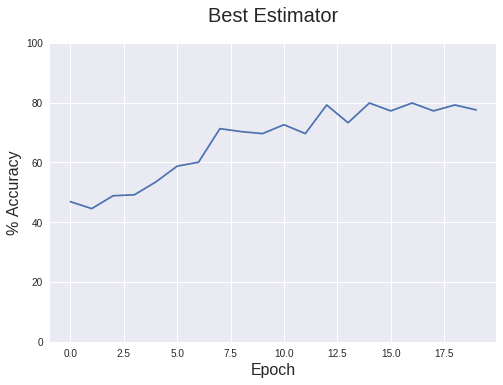

Best: 0.802 using {'reg': 0.2}

Means: 80.198, Stdev: 4.201 with: {'reg': 0.2}
Means: 78.878, Stdev: 0.467 with: {'reg': 0.4}


In [92]:
grid_result = grid_result7

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

In [95]:
# Putting the indepedent best parameters together
# -----------------------------------------------

# Function to create model, required for KerasClassifier
def create_model(reg):
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(13, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(13, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    adam = optimizers.Adam(lr=.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1,
                       batch_size=10, epochs=50)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result8 = grid.fit(X, y)

Epoch 1/50
242/242 [==============================] - 28s 117ms/step - loss: 0.6808 - acc: 0.5331
Epoch 2/50
242/242 [==============================] - 0s 1ms/step - loss: 0.4794 - acc: 0.8182
Epoch 3/50
242/242 [==============================] - 0s 1ms/step - loss: 0.4310 - acc: 0.8182
Epoch 4/50
242/242 [==============================] - 0s 1ms/step - loss: 0.3768 - acc: 0.8595
Epoch 5/50
242/242 [==============================] - 0s 1ms/step - loss: 0.3803 - acc: 0.8471
Epoch 6/50
242/242 [==============================] - 0s 1ms/step - loss: 0.3732 - acc: 0.8595
Epoch 7/50
242/242 [==============================] - 0s 1ms/step - loss: 0.3645 - acc: 0.8512
Epoch 8/50
242/242 [==============================] - 0s 1ms/step - loss: 0.3244 - acc: 0.8802
Epoch 9/50
242/242 [==============================] - 0s 1ms/step - loss: 0.3232 - acc: 0.8760
Epoch 10/50
242/242 [==============================] - 0s 1ms/step - loss: 0.2932 - acc: 0.8967
Epoch 11/50
242/242 [=========================

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/50
303/303 [==============================] - 29s 97ms/step - loss: 0.6828 - acc: 0.5677
Epoch 2/50
303/303 [==============================] - 0s 1ms/step - loss: 0.5162 - acc: 0.7591
Epoch 3/50
303/303 [==============================] - 0s 1ms/step - loss: 0.4607 - acc: 0.8020
Epoch 4/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3916 - acc: 0.8383
Epoch 5/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3958 - acc: 0.8515
Epoch 6/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3941 - acc: 0.8581
Epoch 7/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3771 - acc: 0.8482
Epoch 8/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3663 - acc: 0.8581
Epoch 9/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3774 - acc: 0.8548
Epoch 10/50
303/303 [==============================] - 0s 1ms/step - loss: 0.3456 - acc: 0.8548
Epoch 11/50
303/303 [==========================

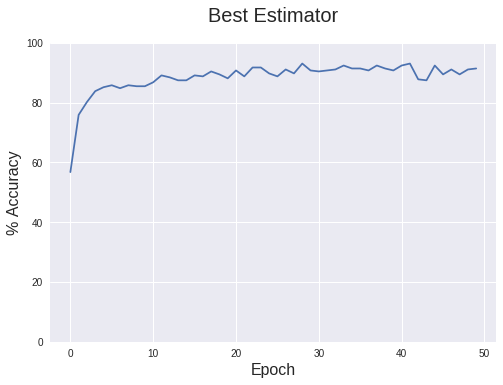

Best: 0.848 using {'reg': 0.4}

Means: 84.158, Stdev: 4.616 with: {'reg': 0.2}
Means: 84.818, Stdev: 2.949 with: {'reg': 0.4}


In [96]:
grid_result = grid_result8

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 